In [2]:
import numba
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

def add_gaussian_noise(data, std_dev, mean=0):
    noise = np.random.normal(mean, std_dev, size=data.shape)
    noisy_data = data + noise
    return noisy_data
    

@numba.jit(nopython=True)
def cubic_root(x):
    """Compute cubic root of a number while maintaining its sign.
    
    x: (complex) The number.
    """
    
    third = 1./3.
    
    if x.real >= 0:
        return x**third
    else:
        return -(-x)**third
    
    
@numba.jit(nopython=True)
def cubicRealRoot(a, b, c):
    """Analytical closed-form solver for a single cubic equation.
    x^3 + a*x^2 + bx + c = 0
    Gives only one real root.
    
    a, b, c: (float) Cubic coeficients.
    """
    
    third = 1./3.
    a13 = a*third
    a2 = a13*a13
    f = third*b - a2
    g = a13 * (2*a2 - b) + c
    h = 0.25*g*g + f*f*f

    if f == g == h == 0:
        return -cubic_root(c)

    elif h.real <= 0:
        j = np.sqrt(-f)
        k = np.arccos(-0.5*g / (j*j*j))
        m = np.cos(third*k)
        return 2*j*m - a13

    else:
        sqrt_h = cmath.sqrt(h)
        S = cubic_root(-0.5*g + sqrt_h)
        U = cubic_root(-0.5*g - sqrt_h)
        S_plus_U = S + U
        return S_plus_U - a13
    
    
def xSolver(fi, Pi, f0, Es, Qr, Qc):
    """Solve for x, the detuning.
    
    fi: Frequency of bin.
    Pi: Input power in bin.
    f0, Es, Qr, Qc: See modelKid() decription.
    """
    
    from numpy.polynomial import polynomial
    
    x0 = (fi - f0)/f0
    a = 2*Qr**3*Pi/Qc/fi/Es
    # c3 = 1
    c2 = -x0
    c1 = 1/(4*Qr**2)
    c0 = -1/(4*Qr**2)*(a/Qr + x0)
    
    # I first tried sympy solver but waaay too slow
    # This is a numpy polyroots solution; this is still too slow
    # sols = polynomial.polyroots((c0,c1,c2,c3))
    # try:
    #     sol = sols[np.isreal(sols)][0] # return first real solution
    # except:
    #     sol = 0
    
    # I found a custom cubic solver online
    # this is much faster and has potential for vectorized sols
    # https://github.com/NKrvavica/fqs
    # sol = single_cubic_one(c3, c2, c1, c0)
    sol = cubicRealRoot(c2, c1, c0)
    
    return sol


# def modelKid(f, P, f0, Es, Qr, Qc, yi, A):
#     """Simple KID model.
    
#     f:  Frequency in all bins, array.
#     P:  Input power in all bins, array.
#     f0: Resonance frequency of KID.
#     Es: Scaling energy constant of KID.
#     Qr: Overall loaded quality factor of KID.
#     Qc: Coupling quality factor of KID.
#     yi: Continuum asymmetry.
#     A:  Amplitude scaling constant.
#     """
    
#     x = np.array([
#         xSolver(f[i], P[i], f0, Es, Qr, Qc) 
#         for i in range(len(f))
#     ])
    
#     ## frequency shift based on power
#     E_r = (2*(Qr**2)*P)/(Qc*(1 + 4*(np.diff(x, append=x[-1]))**2*Qr**2)*f0)
#     x = x - E_r/(0.5*1.7e10*2300*200**2)
    
#     yr = np.sqrt(1 - yi**2)
#     y = (1 + yi*1j)
#     print(Qr)
#     Qr = Qr/P
#     print(Qr)
    
#     S21 = A*(1 - (Qr/Qc)*y/(1+2j*Qr*x))
#     #S21[S21<0] = 0
    
#     return S21

def modelKid(f, P, f0, Es, Qr, Qc, yi, A):
    """Simple KID model.
    
    f:  Frequency in all bins, array.
    P:  Input power in all bins, array.
    f0: Resonance frequency of KID.
    Es: Scaling energy constant of KID.
    Qr: Overall loaded quality factor of KID.
    Qc: Coupling quality factor of KID.
    yi: Continuum asymmetry.
    A:  Amplitude scaling constant.
    """
    
    x = np.array([
        xSolver(f[i], P[i], f0, Es, Qr, Qc) 
        for i in range(len(f))
    ])
    
    ## frequency shift based on power
    E_r = (2*(Qr**2)*P)/(Qc*(1 + 4*(np.diff(x, append=x[-1]))**2*Qr**2)*f0)
    x = x + 1e5*E_r
    
    yr = np.sqrt(1 - yi**2)
    y = (1 + yi*1j)
    
    # changing Qr based on power
    Qr =  (1 - 0.25*(1 -(0.1/P[1]))) * Qr
    
    
    S21 = 1 - A*(Qr/Qc)*y/(1+2j*Qr*x)
    
    
    
    #S21[S21<0] = 0
    
    return S21


freqs = np.linspace(4e8, 8e8, 50000)

S21 = modelKid(f=freqs, P=np.ones_like(freqs)*300e4, f0=600e6, Es=6000, Qr=10000, Qc=30000, yi=0.6, A=2+1j)

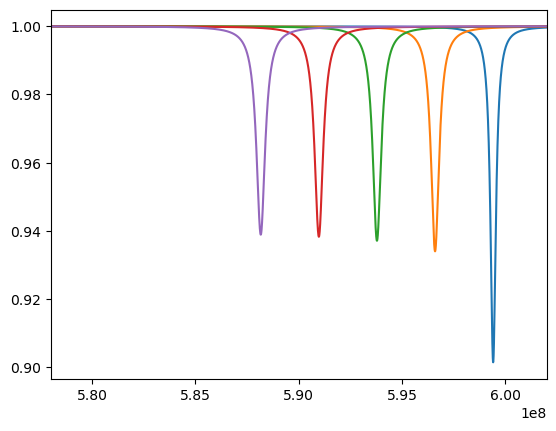

In [3]:
vals = np.linspace(0.05, 1, 5)
S21dat = []
for i in range(len(vals)):
    
    freqs = np.linspace(5e8, 7e8, 50000)
    S21 = modelKid(f=freqs, P=np.ones_like(freqs)*vals[i], f0=600e6, Es=1, Qr=1500, Qc=38000, yi=0, A=2)
    S21dat.append(add_gaussian_noise(S21, std_dev=2/1e3))
    plt.plot(freqs, np.abs(S21))

#plt.xlim(0.9*600e6,1.1*600e6)
plt.xlim(578e6, 602e6)   
plt.show()

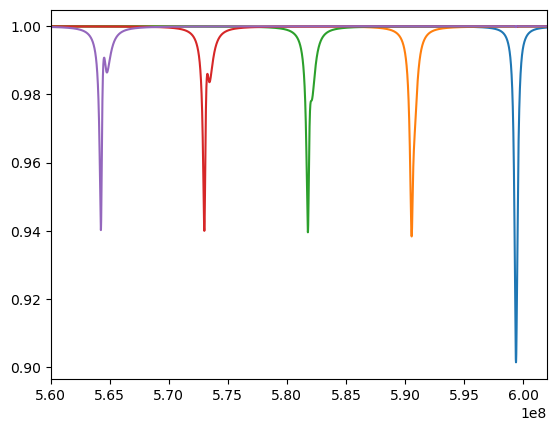

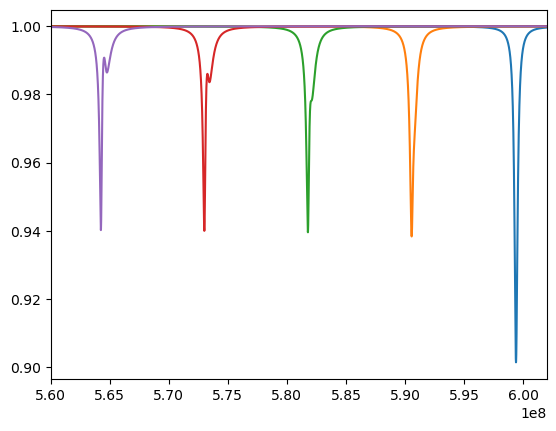

In [4]:
# adding enrgy params -> lead up to bifurcation, the simple way? using swenson

def modelKid(f, P, f0, Es, Qr, Qc, yi, A, E_star=600e-6):
    """Simple KID model.
    
    f:  Frequency in all bins, array.
    P:  Input power in all bins, array.
    f0: Resonance frequency of KID.
    Es: Scaling energy constant of KID.
    Qr: Overall loaded quality factor of KID.
    Qc: Coupling quality factor of KID.
    yi: Continuum asymmetry.
    A:  Amplitude scaling constant.
    """
    
    x = np.array([
        xSolver(f[i], P[i], f0, Es, Qr, Qc) 
        for i in range(len(f))
    ])
    
    ## frequency shift based on power
    E_r = (2*(Qr**2)*P)/(Qc*(1 + 4*(np.diff(x, append=x[-1]))**2*Qr**2)*f0)
    x = x + 1e5*E_r
    
    #adding bifurcation
    bifur = (2*Qr**2*P)/(Qc*(1 + 4*Qr**2*x**2)*f0*E_star)
    x = x + bifur
    
    yr = np.sqrt(1 - yi**2)
    y = (1 + yi*1j)
    
    # changing Qr based on power
    Qr =  (1 - 0.25*(1 -(0.1/P[1]))) * Qr
    
    
    S21 = 1 - A*(Qr/Qc)*y/(1+2j*Qr*x)
    
    
    
    #S21[S21<0] = 0
    
    return S21

vals = np.linspace(0.05, 3, 5)
S21dat = []
for i in range(len(vals)):
    
    freqs = np.linspace(5e8, 7e8, 50000)
    S21 = modelKid(f=freqs, P=np.ones_like(freqs)*vals[i], f0=600e6, Es=600e-6, Qr=1500, Qc=38000, yi=1, A=1-1j)
    S21dat.append(add_gaussian_noise(S21, std_dev=2/1e3))
    plt.plot(freqs, np.abs(S21))

#plt.xlim(0.9*600e6,1.1*600e6)
plt.xlim(560e6, 602e6)   
plt.show()

vals = np.linspace(0.05, 3, 5)
S21dat = []
for i in range(len(vals)):
    
    freqs = np.linspace(5e8, 7e8, 50000)
    S21 = modelKid(f=freqs, P=np.ones_like(freqs)*vals[i], f0=600e6, Es=1, Qr=1500, Qc=38000, yi=1, A=1-1j)
    S21dat.append(add_gaussian_noise(S21, std_dev=2/1e3))
    plt.plot(freqs, np.abs(S21))

#plt.xlim(0.9*600e6,1.1*600e6)
plt.xlim(560e6, 602e6)   
plt.show()

In [164]:
# adding enrgy params -> lead up to bifurcation


def Kmod(freqs, Pows, f0, El, Ed, Es, Qr, Qc, yi, A):
    """ KID model.
    
    freqs:  Frequency in all bins, array.
    Powers:  Input power in all bins, array.
    f0: Resonance frequency of KID.
    El: Loading energy of KID
    Ed: Dissipation energy of KID 
    Es: Scaling energy constant of KID.
    Qr: Overall loaded quality factor of KID.
    Qc: Coupling quality factor of KID.
    yi: Continuum asymmetry.
    A:  Amplitude scaling constant.
    
    """
    
    
    x = np.array([
        xSolver(freqs[i], Pows[i], f0, Es, Qr, Qc) 
        for i in range(len(f))])
    
    ## frequency shift based on power
    E_r = (2*(Qr**2)*Pows)/(Qc*(1 + 4*(np.diff(x, append=x[-1]))**2*Qr**2)*f0)
    x = x + 1e5*E_r
    
    yr = np.sqrt(1 - yi**2)
    y = (1 + yi*1j)
    
    # changing Qr based on power
    Qr =  (1 - 0.25*(1 -(0.1/Pows[1]))) * Qr
    
    
    for i,f in enumerate(freqs):
        x = xSolver(f, Pows[i], f0, Es, Qr, Qc)
        
        
        
        
        
        S21_now = 1 - A*(Qr/Qc)*y/(1+2j*Qr*x)
        
    
    
    
    return I_1, Q_1, E_l 

In [101]:
freqs = np.linspace(4e8, 8e8, 50000)
x = Kmod(f=freqs, P=np.ones_like(freqs)*0.1, f0=600e6, El=0, Ed=0, Es=1, Qr=1500, Qc=38000, yi=0, A=2)
x

array([-0.3313628 +0.j, -0.33134947+0.j, -0.33133613+0.j, ...,
        0.3352772 +0.j,  0.33529053+0.j,  0.33530702+0.j])

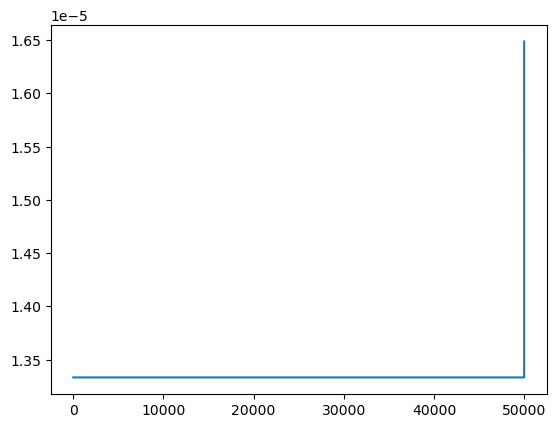

In [102]:
plt.plot(np.diff(x))

In [79]:
p = np.array([1,1,3,4,5,4,3,1,1])

In [80]:
np.diff(p)

array([ 0,  2,  1,  1, -1, -1, -2,  0])

In [93]:
np.diff(p, append=p[-1])

array([ 0,  2,  1,  1, -1, -1, -2,  0,  0])

In [225]:
2*5**2*2

100

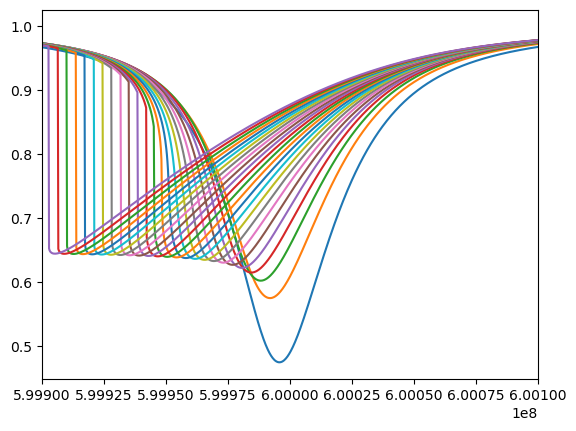

In [224]:
import numba
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

def add_gaussian_noise(data, std_dev, mean=0):
    noise = np.random.normal(mean, std_dev, size=data.shape)
    noisy_data = data + noise
    return noisy_data
    

@numba.jit(nopython=True)
def cubic_root(x):
    """Compute cubic root of a number while maintaining its sign.
    
    x: (complex) The number.
    """
    
    third = 1./3.
    
    if x.real >= 0:
        return x**third
    else:
        return -(-x)**third
    
    
@numba.jit(nopython=True)
def cubicRealRoot(a, b, c):
    """Analytical closed-form solver for a single cubic equation.
    x^3 + a*x^2 + bx + c = 0
    Gives only one real root.
    
    a, b, c: (float) Cubic coeficients.
    """
    
    third = 1./3.
    a13 = a*third
    a2 = a13*a13
    f = third*b - a2
    g = a13 * (2*a2 - b) + c
    h = 0.25*g*g + f*f*f

    if f == g == h == 0:
        return -cubic_root(c)

    elif h.real <= 0:
        j = np.sqrt(-f)
        k = np.arccos(-0.5*g / (j*j*j))
        m = np.cos(third*k)
        return 2*j*m - a13

    else:
        sqrt_h = cmath.sqrt(h)
        S = cubic_root(-0.5*g + sqrt_h)
        U = cubic_root(-0.5*g - sqrt_h)
        S_plus_U = S + U
        return S_plus_U - a13
    
    
def xSolver(fi, Pi, f0, Es, Qr, Qc):
    """Solve for x, the detuning.
    
    fi: Frequency of bin.
    Pi: Input power in bin.
    f0, Es, Qr, Qc: See modelKid() decription.
    """
    
    from numpy.polynomial import polynomial
    
    x0 = (fi - f0)/f0
    a = 2*Qr**3*Pi/Qc/f0/Es
    # c3 = 1
    c2 = -x0
    c1 = 1/(4*Qr**2)
    c0 = -1/(4*Qr**2)*(a/Qr + x0)
    
    # I first tried sympy solver but waaay too slow
    # This is a numpy polyroots solution; this is still too slow
    # sols = polynomial.polyroots((c0,c1,c2,c3))
    # try:
    #     sol = sols[np.isreal(sols)][0] # return first real solution
    # except:
    #     sol = 0
    
    # I found a custom cubic solver online
    # this is much faster and has potential for vectorized sols
    # https://github.com/NKrvavica/fqs
    # sol = single_cubic_one(c3, c2, c1, c0)
    sol = cubicRealRoot(c2, c1, c0)
    
    return sol


# def modelKid(f, P, f0, Es, Qr, Qc, yi, A):
#     """Simple KID model.
    
#     f:  Frequency in all bins, array.
#     P:  Input power in all bins, array.
#     f0: Resonance frequency of KID.
#     Es: Scaling energy constant of KID.
#     Qr: Overall loaded quality factor of KID.
#     Qc: Coupling quality factor of KID.
#     yi: Continuum asymmetry.
#     A:  Amplitude scaling constant.
#     """
    
#     x = np.array([
#         xSolver(f[i], P[i], f0, Es, Qr, Qc) 
#         for i in range(len(f))
#     ])
    
#     ## frequency shift based on power
#     E_r = (2*(Qr**2)*P)/(Qc*(1 + 4*(np.diff(x, append=x[-1]))**2*Qr**2)*f0)
#     x = x - E_r/(0.5*1.7e10*2300*200**2)
    
#     yr = np.sqrt(1 - yi**2)
#     y = (1 + yi*1j)
#     print(Qr)
#     Qr = Qr/P
#     print(Qr)
    
#     S21 = A*(1 - (Qr/Qc)*y/(1+2j*Qr*x))
#     #S21[S21<0] = 0
    
#     return S21

def modelKid(f, P, f0, Es, Qr, Qc, yi, A):
    """Simple KID model.
    
    f:  Frequency in all bins, array.
    P:  Input power in all bins, array.
    f0: Resonance frequency of KID.
    Es: Scaling energy constant of KID.
    Qr: Overall loaded quality factor of KID.
    Qc: Coupling quality factor of KID.
    yi: Continuum asymmetry.
    A:  Amplitude scaling constant.
    """
    
    x = np.array([
        xSolver(f[i], P[i], f0, Es, Qr, Qc) 
        for i in range(len(f))
    ])
    
#     ## frequency shift based on power
#     E_r = (2*(Qr**2)*P)/(Qc*(1 + 4*(np.diff(x, append=x[-1]))**2*Qr**2)*f0)
#     x = x + 1e5*E_r
    
    yr = np.sqrt(1 - yi**2)
    y = (1 + yi*1j)
    
    # changing Qr based on power
    Qc =  (1 + 0.5*(1 -(0.08/P[1]))) * Qc
    
    
    S21 = 1 - A*(Qr/Qc)*y/(1+2j*Qr*x)
    
    
    
    #S21[S21<0] = 0
    
    return S21


freqs = np.linspace(4e8, 8e8, 50000)

S21 = modelKid(f=freqs, P=np.ones_like(freqs)*300e4, f0=600e6, Es=6000, Qr=10000, Qc=30000, yi=0.6, A=2+1j)

vals = np.linspace(0.08, 1.8, 25)
S21dat = []
for i in range(len(vals)):
    
    freqs = np.linspace(5.99e8, 6.1e8, 50000)
    S21 = modelKid(f=freqs, P=np.ones_like(freqs)*vals[i], f0=600e6, Es=0.1, Qr=10000, Qc=38000, yi=0, A=2)
    S21dat.append(add_gaussian_noise(S21, std_dev=2/1e3))
    plt.plot(freqs, np.abs(S21))

#plt.xlim(0.9*600e6,1.1*600e6)
plt.xlim(599.90e6, 600.1e6)   
plt.show()

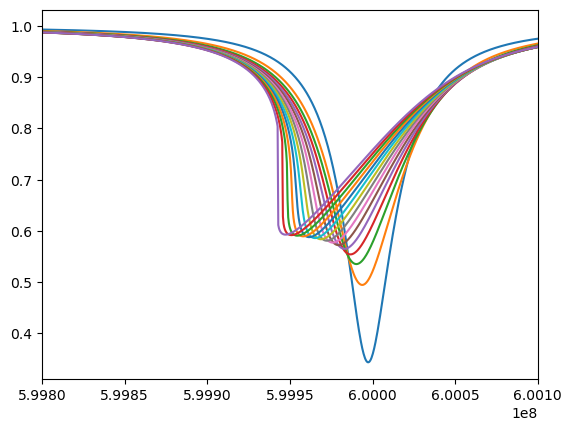

In [7]:
import numba
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

def add_gaussian_noise(data, std_dev, mean=0):
    noise = np.random.normal(mean, std_dev, size=data.shape)
    noisy_data = data + noise
    return noisy_data
    

@numba.jit(nopython=True)
def cubic_root(x):
    """Compute cubic root of a number while maintaining its sign.
    
    x: (complex) The number.
    """
    
    third = 1./3.
    
    if x.real >= 0:
        return x**third
    else:
        return -(-x)**third
    
    
@numba.jit(nopython=True)
def cubicRealRoot(a, b, c):
    """Analytical closed-form solver for a single cubic equation.
    x^3 + a*x^2 + bx + c = 0
    Gives only one real root.
    
    a, b, c: (float) Cubic coeficients.
    """
    
    third = 1./3.
    a13 = a*third
    a2 = a13*a13
    f = third*b - a2
    g = a13 * (2*a2 - b) + c
    h = 0.25*g*g + f*f*f

    if f == g == h == 0:
        return -cubic_root(c)

    elif h.real <= 0:
        j = np.sqrt(-f)
        k = np.arccos(-0.5*g / (j*j*j))
        m = np.cos(third*k)
        return 2*j*m - a13

    else:
        sqrt_h = cmath.sqrt(h)
        S = cubic_root(-0.5*g + sqrt_h)
        U = cubic_root(-0.5*g - sqrt_h)
        S_plus_U = S + U
        return S_plus_U - a13
    
    
def xSolver(fi, Pi, f0, Es, Qr, Qc):
    """Solve for x, the detuning.
    
    fi: Frequency of bin.
    Pi: Input power in bin.
    f0, Es, Qr, Qc: See modelKid() decription.
    """
    
    from numpy.polynomial import polynomial
    
    x0 = (fi - f0)/f0
    a = 2*Qr**3*Pi/Qc/f0/Es
    # c3 = 1
    c2 = -x0
    c1 = 1/(4*Qr**2)
    c0 = -1/(4*Qr**2)*(a/Qr + x0)

    sol = cubicRealRoot(c2, c1, c0)
    
    return sol

def modelKid(f, P, f0, Es, Qr, Qc, yi, A):
    """Simple KID model.
    
    f:  Frequency in all bins, array.
    P:  Input power in all bins, array.
    f0: Resonance frequency of KID.
    Es: Scaling energy constant of KID.
    Qr: Overall loaded quality factor of KID.
    Qc: Coupling quality factor of KID.
    yi: Continuum asymmetry.
    A:  Amplitude scaling constant.
    """
    
    x = np.array([
        xSolver(f[i], P[i], f0, Es, Qr, Qc) 
        for i in range(len(f))
    ])
    
#     ## frequency shift based on power
#     E_r = (2*(Qr**2)*P)/(Qc*(1 + 4*(np.diff(x, append=x[-1]))**2*Qr**2)*f0)
#     x = x + 1e5*E_r
    
    yr = np.sqrt(1 - yi**2)
    y = (1 + yi*1j)
    
    # changing Qr based on power
    Qr =  (1 - 0.25*(1 -(0.1/P[1]))) * Qr
    
    
    S21 = 1 - A*(Qr/Qc)*y/(1+2j*Qr*x)
    
    
    
    #S21[S21<0] = 0
    
    return S21


freqs = np.linspace(5e9, 7e8, 50000)

S21 = modelKid(f=freqs, P=np.ones_like(freqs)*300e4, f0=600e6, Es=6000, Qr=10000, Qc=30000, yi=0.6, A=2+1j)

vals = np.linspace(0.05, 1, 15)
S21dat = []
for i in range(len(vals)):
    
    freqs = np.linspace(5e8, 7e8, 500000)
    S21 = modelKid(f=freqs, P=np.ones_like(freqs)*vals[i], f0=600e6, Es=0.1, Qr=10000, Qc=38000, yi=0, A=2)
    S21dat.append(add_gaussian_noise(S21, std_dev=2/1e3))
    plt.plot(freqs, np.abs(S21))

#plt.xlim(0.9*600e6,1.1*600e6)
plt.xlim(599.8e6, 600.1e6)   
#plt.yscale('log')
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
class Kid:
    def __init__(self, f0, Qr=10000, Qc=38000, yi=0, Ed = 0, E = 0) -> None:
        """
        f0: f0: Resonance frequency of KID.
        E: Starting Loading energy of KID
        Ed: Dissipation energy of KID 
        Qr: Overall loaded quality factor of KID.
        Qc: Coupling quality factor of KID.
        yi: Continuum asymmetry.
        """
        self.f0 = f0
        self.Qr = Qr
        self.Qc = Qc
        self.yi = yi
        self.E = E
        self.Ed = Ed
        self.Qi = (Qr**-1 - Qc**-1)**-1
        pass

    def vnaSweep(self, start, stop, n, P, speed):
        S_21 = []
        freqs = np.linspace(start, stop, n)
        Pows = np.ones_like(freqs)*P
        for i, f in enumerate(freqs):
            tfromsig = 1/speed
            S_21_now = self.hit(f, Pows[i], tfromsig)
            S_21.append(S_21_now)
        S_21 = np.array(S_21)
        # plt.plot(freqs, np.abs(S_21))
        # plt.show()
        # plt.plot(S_21.real, S_21.imag)
        # plt.show()
        return S_21
    
    def hit(self, freq, pow, tfromsig):
        ex = (self.f0 - freq)/freq
        E_new = self.E + ((2*self.Qr**2*pow) / (self.Qc* (1 + 4*self.Qr**2*ex**2*self.f0)))
        self.E = E_new - self.Ed
        self.update()
        Escaling = 10
        ex = (self.f0 - freq)/freq + E_new/Escaling
        S_21now = 1 - (self.Qr/(self.Qc * (1 + 2j*self.Qr*ex)))
        return S_21now

    def update(self):
        pass

    pass


class Array:
    def __init__(self, loK) -> None:
        vnaSweep()
        pass








In [20]:
%matplotlib qt
K1 = Kid(600e6)
vals = np.linspace(0.05, 3, 15)
for i in range(len(vals)):
    s21 = K1.vnaSweep(550e6, 650e6, 100000, vals[i], 1)
    plt.plot(np.linspace(550e6,650e6,100000), np.abs(s21))
#plt.xlim(0.9*600e6,1.1*600e6)
#plt.xlim(599e6, 601e6)   
plt.show()